# **Image Preprocessing**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


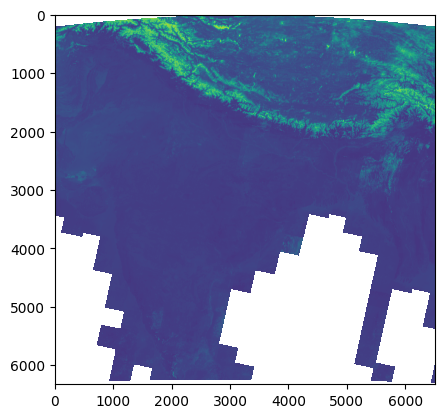

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
dataset = gdal.Open('/content/drive/MyDrive/Copy of landsat_export.tif', gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

In [ ]:
# For no. of bands and resolution
dataset.RasterCount, dataset.RasterXSize, dataset.RasterYSize
# stats about image
# dataset.GetStatistics( True, True )

(12, 6511, 6329)

In [ ]:
import numpy as np

nir_band = dataset.GetRasterBand(5)
swir_band = dataset.GetRasterBand(7)

nir_data = nir_band.ReadAsArray().astype(np.float32)
swir_data = swir_band.ReadAsArray().astype(np.float32)


In [ ]:
# Normalized Difference water index

ndwi = (nir_data - swir_data) / (nir_data + swir_data)

<ipython-input-5-cdfed3a28666>:3: RuntimeWarning: divide by zero encountered in true_divide
  ndwi = (nir_data - swir_data) / (nir_data + swir_data)


In [ ]:
threshold = 0.3 # adjust as needed
water_mask = np.where(ndwi > threshold, 1, 0)

In [ ]:
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create('water_mask.tif', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
out_ds.SetProjection(dataset.GetProjection())
out_ds.SetGeoTransform(dataset.GetGeoTransform())
out_ds.GetRasterBand(1).WriteArray(water_mask)
out_ds = None

In [ ]:
masked_ds = gdal.Open('water_mask.tif', gdal.GA_ReadOnly)
water_mask = masked_ds.GetRasterBand(1).ReadAsArray()

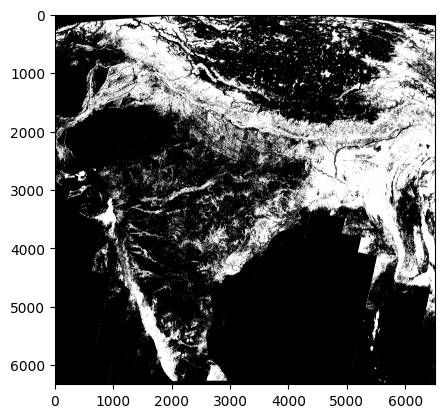

In [ ]:
plt.imshow(water_mask, cmap='gray')
plt.show()

In [ ]:
unique, counts = np.unique(water_mask, return_counts=True)

print(np.asarray((unique, counts)).T)

[[       0 30188008]
 [       1 11020111]]


In [ ]:
water_mask_flat = water_mask.flatten()
water_mask_flat

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
unique, counts = np.unique(water_mask_flat, return_counts=True)

print(np.asarray((unique, counts)).T)

[[       0 30188008]
 [       1 11020111]]


# **PCA of image data**

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA

In [ ]:
water_mask.shape

(6329, 6511)

In [ ]:
water_mask_flat.shape

(41208119,)

In [ ]:
pca = PCA()
pca.fit(water_mask)
pca_components = pca.components_

Number of components explaining 95% variance: 1901


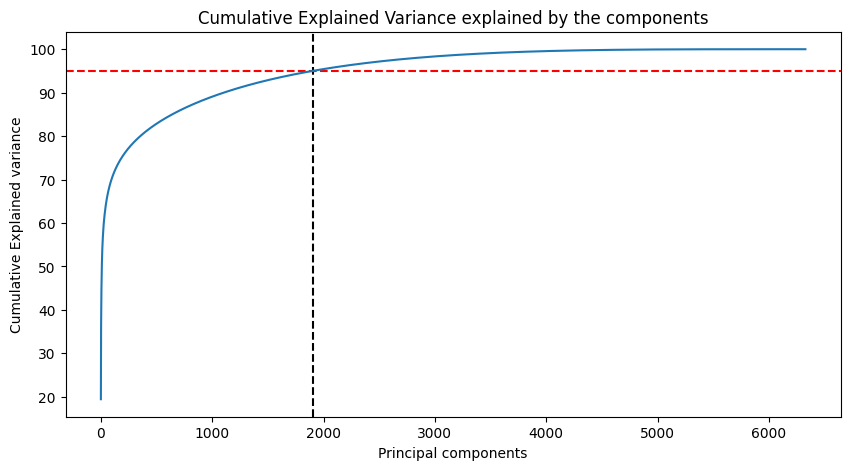

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [ ]:
pca_components

array([[ 0.00335549,  0.00286844,  0.00301057, ...,  0.0125464 ,
         0.01232688,  0.01241743],
       [ 0.00213604,  0.00245625,  0.00227579, ...,  0.00428001,
         0.00470689,  0.00401436],
       [-0.00289355, -0.0032223 , -0.0026433 , ...,  0.01230415,
         0.01273737,  0.01277744],
       ...,
       [ 0.0095435 , -0.00514397, -0.00309344, ...,  0.00674538,
         0.00482886, -0.00230497],
       [-0.07643215,  0.03800658,  0.19726246, ...,  0.00331087,
        -0.00408635, -0.00659156],
       [ 0.03772827, -0.00862864, -0.05480036, ...,  0.00352027,
        -0.00153026,  0.00556373]])

In [ ]:
pca_components.shape

(6329, 6511)

In [ ]:
k

1901

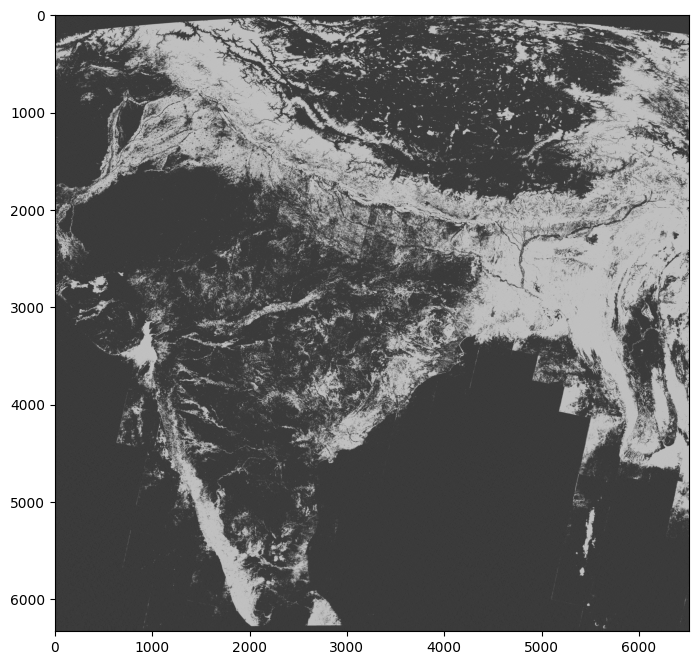

In [ ]:
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(water_mask))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

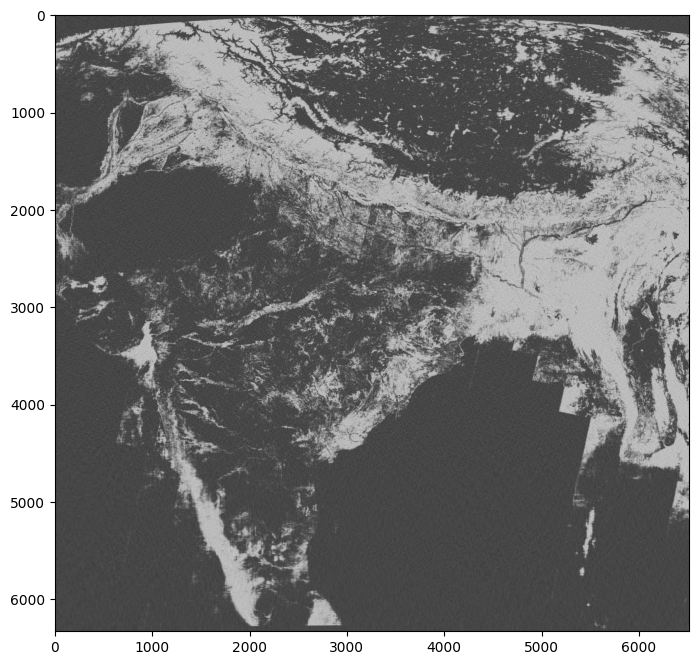

In [ ]:
ipca = IncrementalPCA(n_components=300)
image_recon = ipca.inverse_transform(ipca.fit_transform(water_mask))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)